# Analyse scission


In [1]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.rcParams['figure.figsize'] = [15, 8]

## Datasets selection

In [30]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 64                      # Number of segments in the Kramers chain
n_ensemble = 320                     # Number of molecules to simulate
n_proc = 16                         # Number of processor cores to use
seq = np.random.SeedSequence(2022)  # Random number seed

# Input folder
data_folder = 'outputs/Kramers'
                    
# Name: file
scenarios = [
    'turbulence_0',
    'turbulence_1',
    'turbulence_2',
    'turbulence_3',
    'turbulence_4',
    'inkjet_2',
    'inkjet_3',
    'inkjet_4',
    'inkjet_5',
    'inkjet_7',
    'contraction_0',
    'contraction_1',
    'contraction_2',
    'contraction_3',
    'contraction_4',
    'contraction_5',
    'contraction_6',
    'elongation_0',
    'random_0',
    'random_1',
    'random_2',
    'random_3',
    'random_4',
    'sonication_0',
    'sonication_1',
    'sonication_2',
    'sonication_3',
    'sonication_4',
]
# Load data with rescaling
dataset = {}
for scenario in scenarios:
    with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}__nmol{n_ensemble}.npz") as data:
        temp = dict(data)
        # Rename variables
        tau = 0.0142*n_links**2
        temp['A'] = temp.pop('A_average')/n_links*3
        temp['∇U'] = temp.pop('gradU')*tau
        temp['t'] = temp['t']/tau
        # Add transposed variables
        temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        # Save
        dataset[scenario] = temp

## Simulate scission

For an elongated chain, the maximum tension is at the centre and given by:
$$
g_\max = Wi\left(\frac{N^2}{8} + \frac{N}{2} \right)
$$
So a critical tension corresponds to a critical Weissenberg number
$$
Wi_c = \frac{g_c}{\frac{N^2}{8} + \frac{N}{2}}
$$

In [139]:
Wi_c =  200
threshold = Wi_c/(8*0.0142)
print(threshold)

for scenario, data in dataset.items():
    population = np.zeros_like(data['t'])
    for molecule in data['g_max']:
        for i, g in enumerate(molecule):
            if g < threshold:
                population[i] += 1
            else:
                break
    data['c'] = population/len(data['g_max'])
    data['mlogc'] = -np.log((population+0.001)/len(data['g_max']))

1760.5633802816901


Inspect the result:

In [140]:
def view_scission(scenario):
    plt.rcParams['figure.figsize'] = [15, 10]
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(dataset[scenario]['t'], dataset[scenario]['c'])
    ax[0].set_title('Population')
    
    gradU = dataset[scenario]['∇U']
    D = 0.5*(gradU + np.transpose(gradU, axes=(0,2,1)))
    strains = np.linalg.eigvalsh(D)
    ax[1].plot(dataset[scenario]['t'], strains[:,0])
    ax[1].plot(dataset[scenario]['t'], strains[:,1])
    ax[1].plot(dataset[scenario]['t'], strains[:,2])
    ax[1].set_title('Strain rates')
    plt.show()

ws = interactive(view_scission, 
                 scenario=widgets.Dropdown(
                    options=list(dataset.keys()),
                    value=next(iter(dataset.keys())),
                    description='Scenario:',
                    disabled=False,
                    )
                )
ws

interactive(children=(Dropdown(description='Scenario:', options=('turbulence_0', 'turbulence_1', 'turbulence_2…

## Make library of features

Matrix libraries will take data in the form of a dictionary and access the variables using their name. Therefore we need to specify which names we want to involve in the library by defining `variable_names`. Another useful parameter is the `transpose_map` dictionary where we write information about the transpose of the variables. In this dictionary, a key is a variable name of the dataset, and the value is:
- Same name if the variable is symmetric;
- Same name with a leading `-` if the variable is skew;
- The name of the transpose if it is present in the dataset;
- `None` otherwise.

Here we will be using the stress `'S'` which is symmetric, and both the velocity gradient `'∇U'` and its transposed `'∇Uᵀ'`.

In [93]:
variable_names = {'A', '∇U', '∇Uᵀ'}
transpose_map = {'A':'A', '∇U':'∇Uᵀ', '∇Uᵀ':'∇U'}

Now we can create a new library containing polynomial terms by calling `from_polynomial_matrices`. We need to provide: 
1. `n_terms`: number of mutliplication terms.
2. `intercept`: include the identity matrix as a feature.
3. `symmetry`: symmetry property of the feature. Here we want only symmetric features.

In [94]:
library = FeatureLibrary.from_polynomial_traces(variable_names, transpose_map, n_terms=3, intercept=True)
library

Type of feature output: scalar
Variables names: {'∇Uᵀ', '∇U', 'A'}
Variables transpose map: {'A': 'A', '∇U': '∇Uᵀ', '∇Uᵀ': '∇U'}
Number of feature_functions: 14
(0)	1
(1)	tr(A)
(2)	tr(∇U)
(3)	tr(A∘A)
(4)	tr(A∘∇U)
(5)	tr(∇U∘∇U)
(6)	tr(∇U∘∇Uᵀ)
(7)	tr(A∘A∘A)
(8)	tr(A∘A∘∇U)
(9)	tr(A∘∇U∘∇U)
(10)	tr(A∘∇U∘∇Uᵀ)
(11)	tr(A∘∇Uᵀ∘∇U)
(12)	tr(∇U∘∇U∘∇U)
(13)	tr(∇U∘∇U∘∇Uᵀ)

Before we go on, we will remove `tr(∇U)` from the library as we expect this should be null from imcompressibility assumption.

In [95]:
library.remove_by_name('tr(∇U)')

Type of feature output: scalar
Variables names: {'∇Uᵀ', '∇U', 'A'}
Variables transpose map: {'A': 'A', '∇U': '∇Uᵀ', '∇Uᵀ': '∇U'}
Number of feature_functions: 13
(0)	1
(1)	tr(A)
(2)	tr(A∘A)
(3)	tr(A∘∇U)
(4)	tr(∇U∘∇U)
(5)	tr(∇U∘∇Uᵀ)
(6)	tr(A∘A∘A)
(7)	tr(A∘A∘∇U)
(8)	tr(A∘∇U∘∇U)
(9)	tr(A∘∇U∘∇Uᵀ)
(10)	tr(A∘∇Uᵀ∘∇U)
(11)	tr(∇U∘∇U∘∇U)
(12)	tr(∇U∘∇U∘∇Uᵀ)

Now it is time to combine our matrix library and scalar library.

In [96]:
len(library)

13

We end up with a gigantic library we certainly want to trim, so we do by specifying the maximum degree in each variable:

In [97]:
library.trim({'A':3, '∇U':2, '∇Uᵀ':2})

Type of feature output: scalar
Variables names: {'∇Uᵀ', '∇U', 'A'}
Variables transpose map: {'A': 'A', '∇U': '∇Uᵀ', '∇Uᵀ': '∇U'}
Number of feature_functions: 12
(0)	1
(1)	tr(A)
(2)	tr(A∘A)
(3)	tr(A∘∇U)
(4)	tr(∇U∘∇U)
(5)	tr(∇U∘∇Uᵀ)
(6)	tr(A∘A∘A)
(7)	tr(A∘A∘∇U)
(8)	tr(A∘∇U∘∇U)
(9)	tr(A∘∇U∘∇Uᵀ)
(10)	tr(A∘∇Uᵀ∘∇U)
(11)	tr(∇U∘∇U∘∇Uᵀ)

In [98]:
complexities = []
for name in library.feature_names:
    complexity = 0
    for degree in library.degrees[name].values():
        complexity += degree
    complexities.append(complexity)

## Evaluate strong-form features

For each scenario in the dataset, we evalulate the features from the original (noisy) data and store them in a list. These are features that would be used in a direct application of SINDy.

In [99]:
for scenario, data in dataset.items():
    features = []
    for featurize in library.feature_functions:
        features.append(featurize(data))
    dataset[scenario]['features'] = features

In [100]:
def inspect(scenario, feature):

    t = dataset[scenario]['t']
    f = dataset[scenario]['features'][feature]
    plt.plot(t, f, c='#0c2c84', linewidth=2)
    plt.show()


w = interactive(inspect, scenario=widgets.Dropdown(
                    options=list(dataset.keys()),
                    value=next(iter(dataset.keys())),
                    description='Scenario:',
                    disabled=False,
                    ),
                    feature=widgets.Dropdown(
                    options=list(zip(library.feature_names, range(len(library)))),
                    value=0,
                    description='Feature precursor:',
                    disabled=False,
                    )
               )
w

interactive(children=(Dropdown(description='Scenario:', options=('turbulence_0', 'turbulence_1', 'turbulence_2…

## Make weak-form features

From the literature, weak-form SINDy is more resilient to noisy data. The weak form is simply achieved by projection (weighted sum in our case) onto test functions. Here, we call the test functions *windows*, refering to signal processing. Sampling the weak-form problem is then, for each window, projecting the stress or conformtation tensor onto `diff(window)` and feature onto `window`, where `diff` is a finite differenciation function. In this descrete setting, the strong-form problem with Euler scheme is actually a special case where `window = [0, 1, 0]` and `diff(window) = [0, -1, 1]`.

A few important remarks:

1. Using windows with a larger support acts as a low-pass filter on the features. However, as pointed out by [REF], features are evaluated before this filtering occurs, so that no assumption is made on the smoothness of the origninal data.

2. It is not obvious which window shape we should use. Some are better at filtering out high frequencies but is this really what matters? In our case, we don't know much about the properties of the noise. For example, using a rectangular window is not the best choice for noise, but it brings the problem closer to what we ultimately want to do: evaluate the stress (and not the rate of change, which is only a proxy). Applying a rectangular window is like integrating the data over chunks of time, producing an appraoch similar to that of Hayden Schaeffer and Scott G. McCalla, https://doi.org/10.1103/PhysRevE.96.023302, but avoiding drift.

3. We don't go into the complications of optimal window placement, which is a data selection process after all. At this point, we are still agnostic about the information content of the data, and we make the following choice: for a given window size, windows are distributed to cover the entire data but don't overlap (some data points at the end of the simulated scenario may be excluded). Therefore this approach is equivalent to a low-pass filtering followed by subsampling (in signal processing sense): if we choose a window size greater than one, we end up with less data in the weak form. Now, we can do this process with different window sizes and shapes, and regenerate as many weak-form data points as we want.

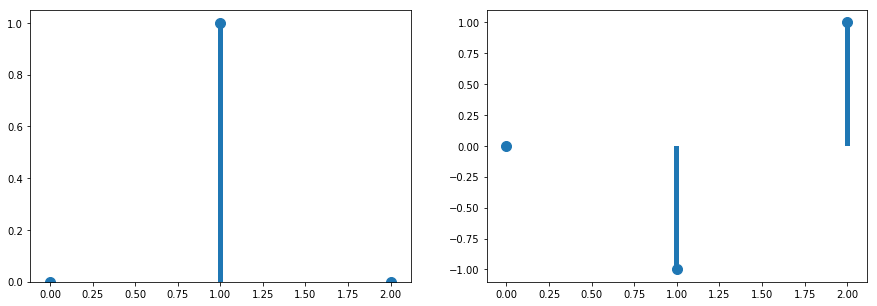

In [117]:
from matsindy.weak import make_window

window = make_window(1, 'rectangular')

width = len(window)
x = np.arange(width)
#print(window)
wind_diff = np.zeros(width)
# derivative: 
wind_diff[1:] = -np.diff(window)
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=2)
ax[0].bar(x, window, width=0.01*width)
ax[0].plot(window,'o',markersize=10)
ax[1].bar(x, wind_diff, width=0.01*width)
ax[1].plot(wind_diff,'o',markersize=10)
plt.show()

### Weak form of target
To find a model of first-order reaction, the target is $(-\log(c))'$. First we need to define $c$ based on critical tension.

In [118]:
from matsindy.weak import weak_diff

ys_dataset = {}
for scenario, data in dataset.items():
    dt = data['t'][1]-data['t'][0]  # Assuming uniform time-step
    ys_dataset[scenario] = weak_diff(data['mlogc'], dt, window)

### Weak form of features

In [119]:
from matsindy.weak import weak_form

# Weak-form features
wfeatures_dataset = {}
for scenario, data in dataset.items():
    dt = data['t'][1]-data['t'][0]
    wfeatures_dataset[scenario] = [weak_form(feature, dt, window) for feature in data['features']]

## Assemble matrix before regression 

Note: at this point, time differentiation has already been done, so the order of data points doesn't matter.

In [120]:
test_scenarios={}

In [121]:
y_train = np.hstack([ys_dataset[scenario].flatten() for scenario in dataset.keys() - test_scenarios])
#y_test = np.hstack([ys_dataset[scenario].flatten() for scenario in test_scenarios])

In [122]:
print(y_train.shape)
#print(y_test.shape)

(23984,)


In [123]:
Xs = []
for scenario in dataset.keys() - test_scenarios:
    flat_features = [feature.flatten() for feature in wfeatures_dataset[scenario]]
    X = np.array(flat_features)
    Xs.append(X.T)
X_train = np.vstack(Xs)

#Xs = []
#for scenario in test_scenarios:
#    flat_features = [feature.flatten() for feature in wfeatures_dataset[scenario]]
#    X = np.array(flat_features)
#    Xs.append(X.T)
#X_test = np.vstack(Xs)

In [124]:
X_train = X_train[y_train>1e-6]
y_train = y_train[y_train>1e-6]

In [125]:
y_train = np.log(y_train)
X_train = np.log(np.abs(X_train))
# Correct fot first column
print(X_train[:, 0])
#X_train[:, 0] = 1

[-8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8.66842304
 -8.66842304 -8.66842304 -8.66842304 -8.66842304 -8

In [126]:
print(X_train.shape)
#print(X_test.shape)

(692, 12)


In [127]:
np.linalg.matrix_rank(X_train)

12

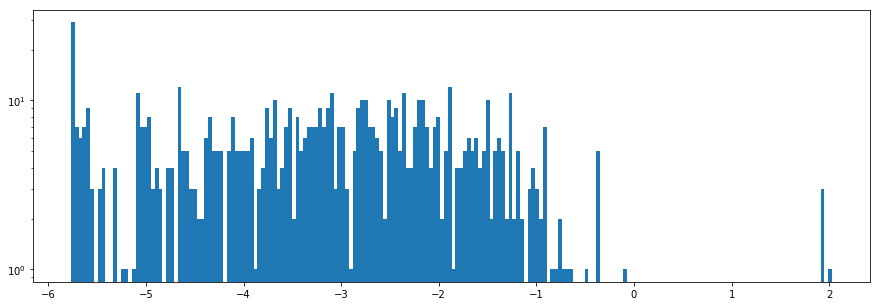

In [128]:
plt.hist(y_train, bins=200)
plt.yscale('log', nonposy='clip')

## Regression

Any algorithm utilising the value of the coefficient to select the models will be sensitive to feature scaling. This may be a problem if an important active term has a low coefficient and therefore cannot be distinguished from noise. Another difficulty is correlation between features, which can cause large coefficient while the combined effect of feature is small.

On the other hand, method based on evolution of the error (or cost of removing a term) are not sensitive to scaling or correlation.

In [129]:
from matsindy.optimizer import fit_from_indices, SSR, SSRD, STLSQ, SBE, SSR_var, SSR_varD, STLSQ_p, SSR_var_softmax

generated_models = {
    'SSR': SSR(X_train, y_train, rescale=True, alpha=0.01),
    'SSRD': SSRD(X_train, y_train, alpha=0.01),
#    'SSR_varD': SSR_varD(X_train, y_train),
    'SSR var': SSR_var(X_train, y_train, alpha=0.01),
    
}

Running SSR...


100%|██████████| 12/12 [00:00<00:00, 2672.95it/s]


Running SSRD...


100%|██████████| 9/9 [00:00<00:00, 1168.33it/s]


Running SSR_var...


100%|██████████| 12/12 [00:00<00:00, 1924.51it/s]


In [130]:
errors = {}
cvs = {}
num_terms = {}
for optim, models in generated_models.items():
    errors[optim] = list(model.error for model in models)
#    cvs[optim] = list(model.compute_cv(X_test, y_test) for model in models)
    num_terms[optim] = list(model.num_terms for model in models)



In [131]:
def view_errors(keys, display_cv, display_10):
    color = iter(cm.Dark2(np.linspace(0, 1, len(keys))))
    for i, optim in enumerate(keys):
        c = next(color)
        plt.semilogy(num_terms[optim], errors[optim], 'o', c=c, label=optim)
        if display_cv:
            plt.semilogy(num_terms[optim], cvs[optim], '*', c=c, label=optim+' cv')
    plt.grid(which='both')
    plt.legend()
    if display_10:
        plt.xlim(1,10)
    plt.show()

we = interactive(view_errors, 
                 keys=widgets.SelectMultiple(
                    options=list(errors.keys()),
                    value=list(errors.keys()),
                    #rows=10,
                    description='Algorithms',
                    disabled=False
                    ),
                 display_cv = widgets.Checkbox(
                    value=False,
                    description='Display cross-validation',
                                ),
                 display_10 = widgets.Checkbox(
                    value=False,
                    description='Display up to 10 terms',
                                )
                )
we

interactive(children=(SelectMultiple(description='Algorithms', index=(0, 1, 2), options=('SSR', 'SSRD', 'SSR v…

In [132]:
def view_model(optim, model):  
    print(optim)
    model.print(library)
    # Plot error dist
    y_hat = model.predict(X_train)
    
    fig, ax = plt.subplots(ncols=2)
    
    ax[0].plot(y_train, y_train, '-', c='gray')
    ax[0].plot(y_train, y_hat, '.', alpha=0.1)
    ax[0].set_ylabel('Predicted value')
    ax[0].set_xlabel('Training value')
    ax[0].set_title('Prediction')
    
    ax[1].hist(y_train-y_hat, bins=200)
    ax[1].set_yscale('log', nonposy='clip')
    ax[1].set_title('Residuals')
    plt.show()

x_widget = widgets.Dropdown(options = list(generated_models.keys()))
y_widget = widgets.Dropdown()

# Define a function that updates the content of y based on what we select for x
def update_models(*args):
    y_widget.options = list((model.num_terms, model) for model in generated_models[x_widget.value])
x_widget.observe(update_models)


wm = interactive(view_model,
         optim = x_widget,
         model = y_widget)
wm

interactive(children=(Dropdown(description='optim', options=('SSR', 'SSRD', 'SSR var'), value='SSR'), Dropdown…

## Simulation error

In [74]:
simulation_scenario = 'random_0_n1000'
model = next(filter(lambda x: x.num_terms == 4, generated_models['Hinch-Larson']))
sim, err = model.simulate('A', dataset[simulation_scenario], library, method='Euler', return_trajectory=True)

KeyError: 'Hinch-Larson'

In [ ]:
t = dataset[simulation_scenario]['t']
obs = dataset[simulation_scenario]['A']

plt.plot(t, obs[:,0,0], c='#0c2c84', linewidth=2, label='xx')
plt.plot(t, sim[:,0,0], '--', c='#0c2c84', linewidth=2, label='xx sim')

plt.plot(t, obs[:,0,1], c='#1d91c0', linewidth=2, label='xy')
plt.plot(t, sim[:,0,1], '--', c='#1d91c0', linewidth=2, label='xy sim')

plt.plot(t, obs[:,0,2], c='#7fcdbb', linewidth=2, label='xz')
plt.plot(t, sim[:,0,2], '--', c='#7fcdbb', linewidth=2, label='xz sim')
plt.legend()
    
plt.show()

## Constrained optimisation

We can constrained the model search by enforcing some physics prior. For example:

- Objectivity (frame invariance): coefficient for A∘∇U + (A∘∇U)ᵀ minus coefficient for A∘∇Uᵀ + (A∘∇Uᵀ)ᵀ should be 1.
- Equilibrium value, typically $A=I$ if $\dot{A}=0$ and $\nabla U = 0$
- Steady-state value, $A=diag(L^2,0,0)$ if $\dot{A}=0$ and $\nabla U = diag(c,-0.5c, -0.5c)$ with $w\gg1$

In [ ]:
upper_conv_index = 4
lower_conv_index = 5
X_objectivity = np.zeros((1, X_train.shape[1]))
X_objectivity[0, upper_conv_index] = 1.
X_objectivity[0, lower_conv_index] = -1.
y_objectivity = np.array([1.])

In [ ]:
equilibrium_data = {
    'A': np.array([np.eye(3)]),
    '∇U': np.array([np.zeros((3, 3))]),
    '∇Uᵀ': np.array([np.zeros((3, 3))])
}
X_equilibrium = np.empty((1, X_train.shape[1]))
for j, featurize in enumerate(library.feature_functions):
    f = featurize(equilibrium_data).flatten()
    X_equilibrium[0, j] = f[0] + f[4] + f[8]
y_equilibrium = np.zeros(1)

In [ ]:
steady_data = {
    'A': np.array([np.diag((L_max**2, 0, 0))]),
    '∇U': np.array([np.diag((10, -5, -5))]),
    '∇Uᵀ': np.array([np.diag((10, -5, -5))])
}
# Based on bounded trace
X_steady = np.empty((1, X_train.shape[1]))
for j, featurize in enumerate(library.feature_functions):
    f =  featurize(steady_data).flatten()
    X_steady[0, j] = f[0] + f[4] + f[8]
y_steady = np.zeros(1)

In [ ]:
Xc = np.vstack((X_objectivity, 
                X_equilibrium, 
#                1e-6*X_steady
               ))
yc = np.hstack((y_objectivity, 
                y_equilibrium, 
#                1e-6*y_steady
               ))

In [ ]:
generated_models[f'Constrained SSR var'] = SSR_var(X_train, y_train, alpha=0.0001, Xc=Xc, yc=yc)
#for i in range(2):
#    generated_models[f'SSR var softmax iter{i}'] = SSR_var_softmax(X_train, y_train, alpha=0.0001)

In [ ]:
for optim, models in generated_models.items():
    errors[optim] = list(model.error for model in models)
    cvs[optim] = list(model.compute_cv(X_test, y_test) for model in models)
    num_terms[optim] = list(model.num_terms for model in models)

In [ ]:
we = interactive(view_errors, 
                 keys=widgets.SelectMultiple(
                    options=list(errors.keys()),
                    value=list(errors.keys()),
                    #rows=10,
                    description='Algorithms',
                    disabled=False
                    ),
                 display_cv = widgets.Checkbox(
                    value=False,
                    description='Display cross-validation',
                                ),
                 display_10 = widgets.Checkbox(
                    value=False,
                    description='Display up to 10 terms',
                                )
                )
we

In [ ]:
x_widget = widgets.Dropdown(options = list(generated_models.keys()))
y_widget = widgets.Dropdown()

# Define a function that updates the content of y based on what we select for x
def update_models(*args):
    y_widget.options = list((model.num_terms, model) for model in generated_models[x_widget.value])
x_widget.observe(update_models)


wm = interactive(view_model,
         optim = x_widget,
         model = y_widget)
wm

In [ ]:
simulation_scenario = 'contraction_0_n1000'
model = next(filter(lambda x: x.num_terms == 3, generated_models['SSR var']))
sim, err = model.simulate('A', dataset[simulation_scenario], library, method='Euler', return_trajectory=True)

t = dataset[simulation_scenario]['t']
obs = dataset[simulation_scenario]['A']

plt.plot(t, obs[:,0,0], c='#0c2c84', linewidth=2, label='xx')
plt.plot(t, sim[:,0,0], '--', c='#0c2c84', linewidth=2, label='xx sim')

plt.plot(t, obs[:,0,1], c='#1d91c0', linewidth=2, label='xy')
plt.plot(t, sim[:,0,1], '--', c='#1d91c0', linewidth=2, label='xy sim')

plt.plot(t, obs[:,0,2], c='#7fcdbb', linewidth=2, label='xz')
plt.plot(t, sim[:,0,2], '--', c='#7fcdbb', linewidth=2, label='xz sim')
plt.legend()
    
plt.show()

## Stability criterion

## Elimination based on coefficient variance

In [ ]:
from scipy.stats import t

X = X_train
y = y_train
d = np.sum(X.shape[1])
M = X.T @ X + 0.0001*np.eye(d)
invXtX = np.linalg.pinv(M)
beta = invXtX @ X.T @ y
error = np.average(np.square(y-np.sum(X*beta, axis=1)))
# t stat
t0 = np.abs(beta)/np.sqrt(error*np.diag(invXtX))
p = t.sf(t0, 100)

In [ ]:
plt.semilogy(t0)
#plt.ylim(0.05,1)

In [ ]:
var_Beta = error*invXtX
beta2 = np.outer(beta, beta)
n_bv = var_Beta/beta2
n_bv[n_bv>-1] = np.nan 

plt.rcParams['figure.figsize'] = [15, 10]
plt.matshow(n_bv)
plt.colorbar()
plt.show()

In [ ]:
plt.hist(var_Beta.flatten()/beta2.flatten(), bins=200)
plt.yscale('log', nonposy='clip')
plt.show()

In [ ]:
active_terms = np.ones(d+2, dtype=bool)
active_terms[1] = False
active_terms[10] = False
betavar = np.zeros((d+2, d+2))*np.nan
dd = invXtX/np.outer(beta, beta)
betavar[np.outer(active_terms, active_terms)] = dd.flatten()
plt.matshow(betavar.reshape((d+2,d+2)))

In [ ]:
dd2.shape

In [ ]:
active_terms

In [ ]:
complexities = []
for name in library.feature_names:
    complexity = 0
    for degree in library.degrees[name].values():
        complexity += degree
    complexities.append(complexity)
complexities

In [ ]:
A = np.arange(10)
A = A.reshape((2,5))

In [ ]:
A

In [ ]:
B = np.sum(A>0, axis=1)
B

In [ ]:
np.all(B > 3)